In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import copy
from torch.nn.modules import Module
from torch import Tensor
from torch import nn as nn
import math
from transformers import BertForSequenceClassification, BertTokenizer, AutoTokenizer, AutoModelForPreTraining

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats as st
from datasets import load_dataset
from itertools import product
import dgl
import networkx as nx

/opt/miniconda3/envs/symb_xai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Visualization Code

In [4]:
from visualization.utils import rescale_score_by_abs, getRGB, span_word, html_heatmap, \
make_text_string, make_color, vis_tree_heat


## XAI Utils

In [15]:
# from explanation import symb_xai, lrp, HOExplainer

In [6]:
from lrp.symbolic_xai import TransformerSymbXAI


## BERT model with 3 layers

In [7]:
params = torch.load('sst2-3layer-model.pt', map_location=torch.device('cpu'))

model = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-SST-2")
model.bert.encoder.layer = model.bert.encoder.layer[:3]

model.bert.encoder.layer[0].intermediate = torch.nn.Identity()
model.bert.encoder.layer[1].intermediate = torch.nn.Identity()
model.bert.encoder.layer[2].intermediate = torch.nn.Identity()

model.bert.encoder.layer[0].output = torch.nn.Identity()
model.bert.encoder.layer[1].output = torch.nn.Identity()
model.bert.encoder.layer[2].output = torch.nn.Identity()

state_dict = model.state_dict()   

for i in range(3):
    state_dict['bert.encoder.layer.{}.attention.self.query.weight'.format(i)] = params['attention_layers.{}.query.weight'.format(i)]
    state_dict['bert.encoder.layer.{}.attention.self.key.weight'.format(i)] = params['attention_layers.{}.key.weight'.format(i)]
    state_dict['bert.encoder.layer.{}.attention.self.value.weight'.format(i)] = params['attention_layers.{}.value.weight'.format(i)]
    
    state_dict['bert.encoder.layer.{}.attention.self.query.bias'.format(i)] = params['attention_layers.{}.query.bias'.format(i)]
    state_dict['bert.encoder.layer.{}.attention.self.key.bias'.format(i)] = params['attention_layers.{}.key.bias'.format(i)]
    state_dict['bert.encoder.layer.{}.attention.self.value.bias'.format(i)] = params['attention_layers.{}.value.bias'.format(i)]
    
    state_dict['bert.encoder.layer.{}.attention.output.dense.weight'.format(i)] = params['attention_layers.{}.output.dense.weight'.format(i)]
    state_dict['bert.encoder.layer.{}.attention.output.dense.bias'.format(i)] = params['attention_layers.{}.output.dense.bias'.format(i)]
    
    state_dict['bert.encoder.layer.{}.attention.output.LayerNorm.weight'.format(i)] = params['attention_layers.{}.output.LayerNorm.weight'.format(i)]
    state_dict['bert.encoder.layer.{}.attention.output.LayerNorm.bias'.format(i)] = params['attention_layers.{}.output.LayerNorm.bias'.format(i)]
    
    state_dict['bert.pooler.dense.weight'] = params['pooler.dense.weight']
    state_dict['bert.pooler.dense.bias'] = params['pooler.dense.bias']
    
    state_dict['classifier.weight'] = params['classifier.weight']
    state_dict['classifier.bias'] = params['classifier.bias']

In [8]:
model.load_state_dict(state_dict)

<All keys matched successfully>

## Explain tiny BERT model on the SST2 dataset

In [37]:
from dgl.data import SSTDataset

mode =  'treebank' # 'treebank' 
if mode == 'huggingface':
    # Load SST2 dataset.
    dataset = load_dataset("sst2", "default")
if mode == 'treebank':
    dataset = SSTDataset(mode='train')
    vocab_words = list(dataset.vocab.keys())


In [38]:
def process_treeid2tokenid(indices, mask, tokens, lsent, verbose=False):
    assert len(mask.nonzero()) == len(lsent), f'len(mask.nonzero()) = {len(mask.nonzero())} != {len(lsent)} = len(indices) '
    cls_id = 0
    sep_id = len(tokens)-1
    
    wordInd2token = {}
    curr_tid = 1 # start with the first token
    for word_tid in range(len(lsent)):
        if tokens[curr_tid] == lsent[word_tid]: 
            wordInd2token[word_tid] = [curr_tid]
            curr_tid += 1
            continue
        else:
            word_string = tokens[curr_tid].replace('##', '')
            tids = [curr_tid]
            while word_string != lsent[word_tid]:
                curr_tid += 1
                word_string += tokens[curr_tid].replace('##', '')
                tids.append(curr_tid)
                if curr_tid == sep_id : 
                    raise RuntimeError(f'Not possible to parse {tokens} into {lsent}')
            
            wordInd2token[word_tid] = tids
            curr_tid += 1
        
    if verbose: print(wordInd2token)
        
    token_indices = []
    for ind in indices:
        word_ids = list(mask.nonzero().squeeze().numpy())
        if ind in word_ids:
            token_indices += wordInd2token[word_ids.index(ind)]
    
    return token_indices

# Analyse the Contrastive Conjunction

Steps:
1. Find sentences that are of the form 'X but Y' where the subsentences X and Y have a different sentiment.
2. Define a constructive explanatory query, to that expresses whether the model was able to detect and use the constrasive conjunction


In [39]:
# find interesting samples for contrastive conjunction


def test_contr_conj(tree, vocab_words, verbose=False):
    input_ids = tree.ndata['x'] # word id of the node
    labels = tree.ndata['y'] #  label of the node
    mask = tree.ndata['mask'] # 1 if the node is a leaf, otherwise 0
    adj= tree.adj()


    lsent = [vocab_words[idw] for idw in input_ids[mask == 1]]
    sentence = make_text_string(lsent)
    label = labels[0] 

    if 'but' in lsent:
        # find the index of 'but' in the tree
        but_treeid = (input_ids == 70).nonzero() # word index of 'but' is 70
        but_sentid = lsent.index('but')
        if len(but_treeid) != 1: return False # skip the sample if there are multiple 'but's
        but_treeid = but_treeid.item()
        assert vocab_words[input_ids[but_treeid]] == 'but'

        # Find the subsentences
        # Find parent node of 'but'
        G = dgl.to_networkx(tree)
        but_parent = list(G.successors(but_treeid))
        assert len(but_parent) == 1, f'sorry parents of "but" are {but_parent}'
        but_parent = but_parent[0]

        # find the subsentence of the parent node of but;
        Xnids = nx.ancestors(G, but_parent)
        Xnids = [nid for sid, nid in enumerate(mask.nonzero().squeeze().numpy()) if nid in Xnids and nid != but_treeid]
        Ynids = [nid for sid, nid in enumerate(mask.nonzero().squeeze().numpy()) if nid not in Xnids and nid != but_treeid]


        # exclusion criterium 1: "X but Y" doesn't reconstructs the whole sentence
        if len(Xnids + [but_treeid] + Ynids) != len(mask.nonzero().squeeze().numpy()): 
            return False

        # exclusion criterium 2: "X" and "Y" are not contrastive
        # find node for subsentence X
        but_parent_leafs = list(G.reverse(copy=True).neighbors(but_parent))
        assert len(but_parent_leafs) == 2 and but_treeid in but_parent_leafs
        X_treeid = but_parent_leafs[0] if but_parent_leafs[0] !=but_treeid else but_parent_leafs[1]

        # find node for subentence Y
        # travel one node higher in the tree
        Xb_parent = list(G.successors(but_parent))
        if len(Xb_parent) != 1: return False
        Xb_parent = Xb_parent[0]
        Xb_parent_leafs = list(G.reverse(copy=True).neighbors(Xb_parent))
        assert len(Xb_parent_leafs) == 2 and but_parent in Xb_parent_leafs
        Y_treeid = Xb_parent_leafs[0] if Xb_parent_leafs[0] != but_parent else Xb_parent_leafs[1]

        ## if the words that correspond to the nodes for X and Y are empty, just skip
        Y_words = [vocab_words[input_ids[nid]] for nid in nx.ancestors(G, Y_treeid) if nid in mask.nonzero().squeeze().numpy() ]
        X_words = [vocab_words[input_ids[nid]] for nid in nx.ancestors(G, X_treeid) if nid in mask.nonzero().squeeze().numpy() ]
        if len(X_words) == 0 or len(Y_words) == 0:
            return False

        ## if the structure of the text is not properly separated into the structure X but Y
        if len(X_words) + len(Y_words) < len(lsent) -2: 
            # note: we substract 2 because 'but' is always missing, '.' if often missing etc.
            return False

        ## if the sentiments of X and Y are the same, just skip
        if int(labels[X_treeid]) > 2 and int(labels[Y_treeid]) < 2:
            pass
        elif int(labels[X_treeid]) < 2 and int(labels[Y_treeid]) > 2:
            pass
        elif (int(labels[X_treeid]) == 2) != (int(labels[Y_treeid]) == 2):
            pass
        else:
            return False

        ## if the sentiment of the full sentence and of Y are not the same, just skip
        if int(labels[Y_treeid]) >=2 and int(labels[0].item()) >= 2:
            pass
        if int(labels[Y_treeid]) <=2 and int(labels[0].item()) <= 2:
            pass
        else:
            return False

        if verbose:
            print('-------')
            print('sid:', sid)
            print('full sentence:', sentence)
            print('ground truth target', labels[0].item())
            print('\n')
            print('subset X is:\n', make_text_string([vocab_words[input_ids[nid]] for nid in  Xnids ]))
            print('subsentence of X node is:\n', make_text_string([vocab_words[input_ids[nid]] for nid in nx.ancestors(G, X_treeid) if nid in mask.nonzero().squeeze().numpy() ] ) )
            print('sentiment of X is:', labels[X_treeid] )
            print('\n')
            print('subset of Y is:\n', make_text_string([vocab_words[input_ids[nid]] for nid in  Ynids ]))
            print('subsentence of Y node is:\n', make_text_string([vocab_words[input_ids[nid]] for nid in nx.ancestors(G, Y_treeid) if nid in mask.nonzero().squeeze().numpy() ] ) )
            print('sentiment of Y is:', labels[Y_treeid] )
            print('\n')
        
        # all good
        return Xnids, Ynids, but_treeid, mask, lsent, sentence
    return False

    
contr_conj_sids = []
for sid in range(len(dataset)):
    tree = dataset[sid]
    cc_out = test_contr_conj(tree, vocab_words, verbose=False)
    if cc_out == False: 
        continue
    else:
        contr_conj_sids.append(sid)

In [40]:
len(contr_conj_sids)

218

In [58]:
from lrp.queries import run_query, Mode

mode = Mode.SUBSET
go = True
all_contr = {key: [] for key in ['R(X)', 'R(X but)', 'R(Y)', 
                                 'R(but Y)', 'R(but)', 'R(X) + R(Y) + R(but)',
                                'R(X but Y)', 'R(X \wedge but \wedge Y)', 'full contr'
#                                  , 'model out'
                                 ]}

embeddings = model.bert.embeddings
tokenizer = BertTokenizer.from_pretrained("textattack/bert-base-uncased-SST-2")

for sid in contr_conj_sids[:100]:
    tree = dataset[sid]
    cc_out = test_contr_conj(tree, vocab_words, verbose=False)
    
    if cc_out == False: 
        continue
    else:
        Xnids, Ynids, but_treeid, mask, lsent, sentence = cc_out
    if len(lsent) > 15:
        continue
    
    print('ok')
    
    target = torch.Tensor([-1,1])
    sample = tokenizer(sentence, return_tensors="pt")
    words = tokenizer.convert_ids_to_tokens(sample['input_ids'].squeeze())
    explainer = TransformerSymbXAI(sample, target, model, embeddings)
    rels = {walk:rel for walk,rel in explainer.walk_relevance()}


    # print(explainer.words)
    # print(lsent)
    tXnids = process_treeid2tokenid(Xnids, mask, tokens=words, lsent=lsent)
    tYnids = process_treeid2tokenid(Ynids,mask, tokens=words, lsent=lsent)
    tbnid = process_treeid2tokenid([but_treeid],mask, tokens=words, lsent=lsent)
    
    # print('mode:', mode)
    all_contr['R(X)'].append( run_query(rels, tXnids, mode=mode))
    all_contr['R(X but)'].append( run_query(rels, tXnids +tbnid, mode=mode) )
    all_contr['R(Y)'].append( run_query(rels, tYnids, mode=mode) )
    all_contr['R(but Y)'].append( run_query(rels, tYnids +tbnid, mode=mode) )
    all_contr['R(but)'].append( run_query(rels, tbnid, mode=mode) )

    all_contr['R(X) + R(Y) + R(but)'].append( 
          run_query(rels, tXnids, mode=mode) 
          + run_query(rels, tYnids, mode=mode) 
          + run_query(rels, tbnid, mode=mode)  )
    all_contr['R(X but Y)'].append( run_query(rels, tXnids + tYnids +tbnid, mode=mode) )
    all_contr['R(X \wedge but \wedge Y)'].append(
          run_query(rels, tXnids + tYnids + tbnid, mode=mode) 
         - run_query(rels, tXnids + tYnids, mode=mode)
          - run_query(rels, tXnids +tbnid, mode=mode)
          - run_query(rels,  tYnids +tbnid, mode=mode)
          + run_query(rels, tbnid, mode=mode)
          + run_query(rels, tYnids , mode=mode)
          + run_query(rels, tXnids, mode=mode)
         )
    all_contr['full contr'].append( sum([ rel for _, rel in rels.items()]))
#     all_contr['model out'].append( (model(explainer.x)*target).sum().item() )

ok
ok
ok
ok
ok
ok
ok


KeyboardInterrupt: 

# Temp test

In [65]:
from explanation import HOExplainer

explainer = HOExplainer(model)
explainer.setup_sample(sentence,target)
rels1 = explainer.explain()
print('ok1')

sample = tokenizer(sentence, return_tensors="pt")
words = tokenizer.convert_ids_to_tokens(sample['input_ids'].squeeze())
explainer = TransformerSymbXAI(sample, target, model, embeddings)
rels2 = {walk:rel for walk,rel in explainer.walk_relevance()}

print('ok2')


ok1
ok2


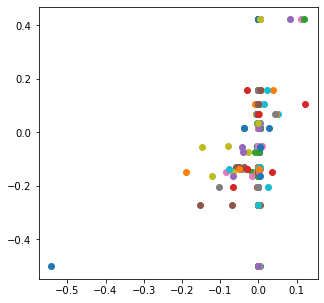

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))

for walk,rel in rels2.items():
    if walk[-1] == 0:
        plt.scatter(rel, rels1[walk[:-1]])

plt.show()

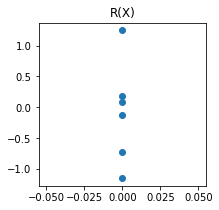

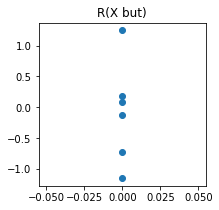

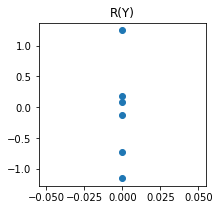

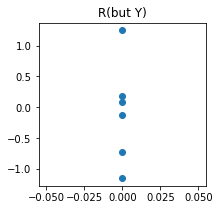

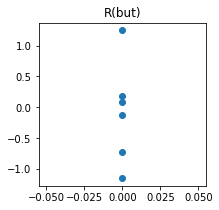

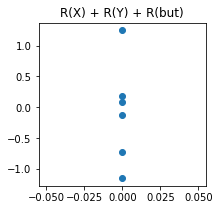

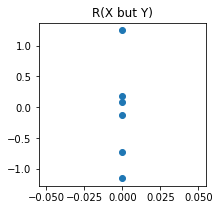

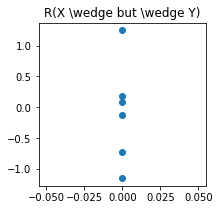

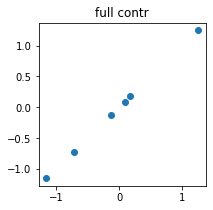

In [64]:
for key, contrs in all_contr.items():
    plt.figure(figsize=(3,3))
    plt.scatter(contrs, all_contr['full contr'])
    plt.title(key)
    plt.show()

In [ ]:
verbose= False
for sid in range(len(dataset)):
    interesting_sids = [30, 54, 60]
    go = False

    if mode == 'huggingface':
        sentence = dataset['validation']['sentence'][sid]
        label = dataset['validation']['label'][sid]

    elif mode == 'treebank':
        tree = dataset[sid]
        input_ids = tree.ndata['x'] # word id of the node
        labels = tree.ndata['y'] #  label of the node
        mask = tree.ndata['mask'] # 1 if the node is a leaf, otherwise 0
        adj= tree.adj()

        lsent = [words[idw] for idw in input_ids[mask == 1]]
        sentence = make_text_string(lsent)
        label = labels[0] 
    
    if 'but' in lsent:
        print(sid)
        print(sentence)
    
    if verbose:
        print(print(sentence))
        print('nb_tokens:', len(explainer.words), 'target:', labels[0].item()) #, explainer.words)
    if go: 
        explainer = HOExplainer(model)
        explainer.setup_sample(sentence,target)
        rels = explainer.explain()
    

In [32]:
i = 14
# hdataset = load_dataset("sst2", "default")
hdataset['validation']['label'][i], hdataset['validation']['sentence'][i]

(0,
 "even horror fans will most likely not find what they 're seeking with trouble every day ; the movie lacks both thrills and humor . ")

In [31]:
# find more interesting sentences 
# check how the gt in the dataset where generated and adapt the evaluation for it

# new dataset movie review

In [32]:
import dgl
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from xai_utils import make_color


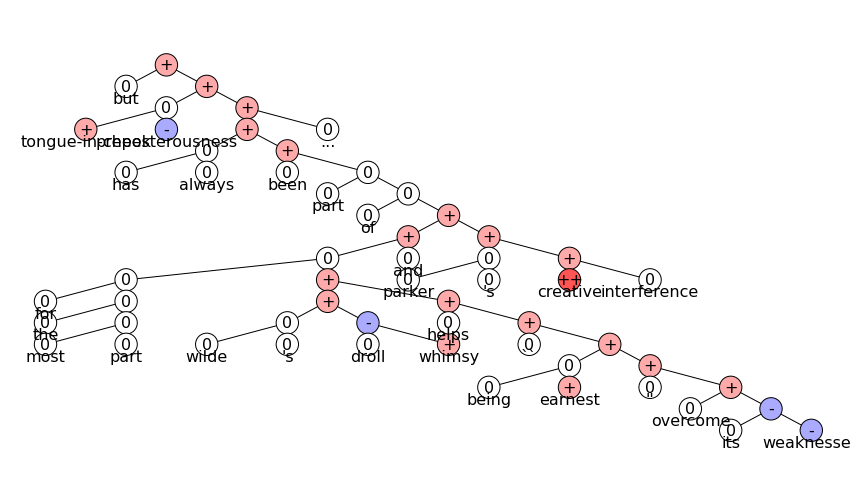

In [226]:
# plot ground truth

tree = dataset[sid]
input_ids = tree.ndata['x'] # word id of the node
labels = tree.ndata['y'] #  label of the node
    
label2sent_symb = {0:'- -', 1: '-', 2:'0', 3: '+', 4:'++'}

node_labels = {i:label2sent_symb[int(label)] for i,label in enumerate(labels)}

node_heat = [make_color( (float(label) - 2.)/3.) for label in labels]

vis_tree_heat(tree, node_heat, words, node_labels=node_labels, 
              save_dir=f'pics/sample{sid}_ground_truth.png',
             word_dist=40,
             node_size=500)


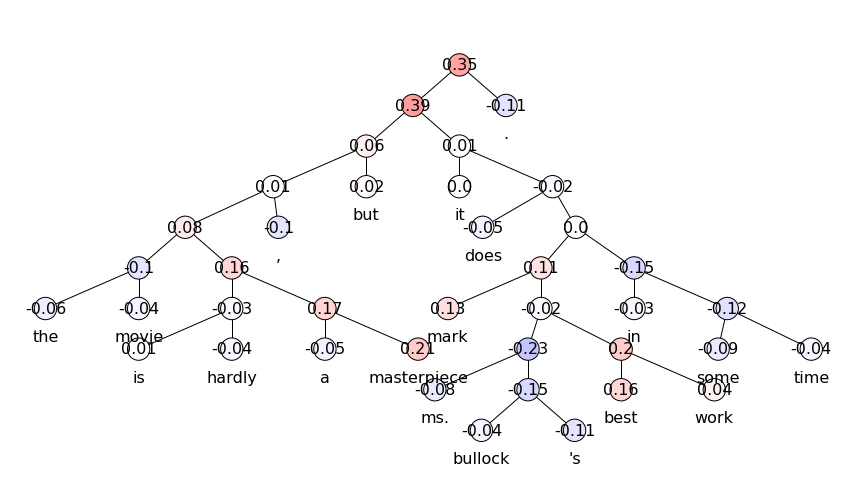

In [175]:
# plot relevance


mode ='subset'

G = dgl.to_networkx(tree)
node_rels = {}
node_labels = {}

for node_id in range(len(labels)):
    ances = nx.ancestors(G, node_id)
    ances.add(node_id)
    
    token_set = process_treeid2tokenid(ances, mask, explainer.words, lsent, verbose=False)
    
    node_rels[node_id] = symb_xai(rels, token_set, mode=mode)
#     node_labels[node_id] = [explainer.words[token] for token in token_set]
    
node_heat = [make_color( rel, scaling=1) for rel in node_rels.values() ]
# node_labels = {i:round(rel,3) for i,rel in enumerate(node_rels.values()) }
node_labels = {i:round(rel,2) for i,rel in enumerate(node_rels.values()) }


vis_tree_heat(tree, node_heat, words,
              node_labels=node_labels, 
              save_dir=f'pics/sample{sid}_contr_{mode}.png',
             node_size=500)
# print(node_rels)

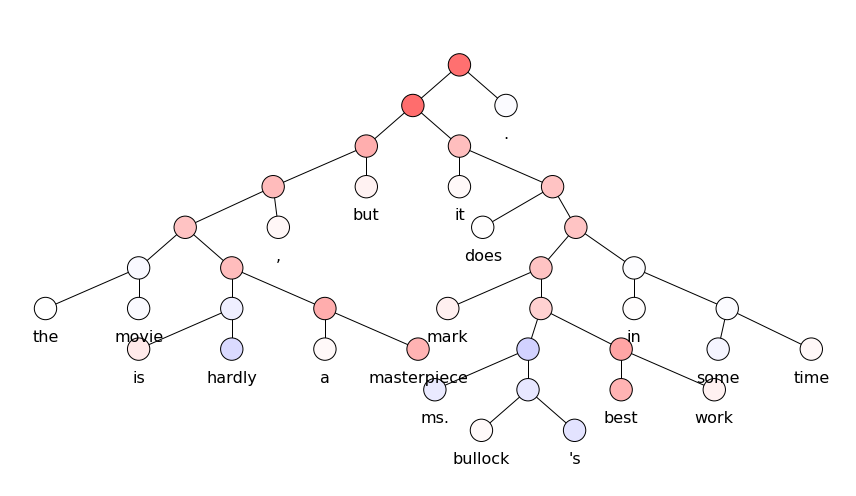

In [177]:
# first order XAI
G = dgl.to_networkx(tree)
node_rels = {}
node_labels = {}

token_rel = {}
for tid in range(len(explainer.words)):
    token_rel[tid] = 0.
    for w, rel in rels.items():
        if w[0] == tid:
            token_rel[tid] += rel

for node_id in range(len(labels)):
    ances = nx.ancestors(G, node_id)
    ances.add(node_id)
    
    token_set = process_treeid2tokenid(ances, mask, tokens=explainer.words, lsent=lsent)
    
    node_rels[node_id] = sum([token_rel[tid] for tid in token_set])

node_heat = [make_color( rel, scaling=.5) for rel in node_rels.values() ]

node_labels = {i: round(rel,2) for i,rel in enumerate(node_rels.values()) }


vis_tree_heat(tree, node_heat, words, 
#               node_labels=node_labels, 
              save_dir=f'pics/sample{sid}_contr_1order.png',
              node_size=500)

In [340]:

def comp_tree_node_rels(rels, tree, mode):
    node_rels = []
    G = dgl.to_networkx(tree)
    mask = mask = tree.ndata['mask']
    
    for node_id in range(len(mask)):
        ances = nx.ancestors(G, node_id)
        ances.add(node_id)

        if mode in ['subset', 'or']:
            token_set = process_treeid2tokenid(ances, mask)
            node_rels.append(symb_xai(rels, token_set, mode=mode))
            
        if mode == '1od':
            token_rel = {}
            token_set = process_treeid2tokenid(ances, mask)

            for tid in range(len(explainer.words)):
                token_rel[tid] = 0.
                for w, rel in rels.items():
                    if w[0] == tid:
                        token_rel[tid] += rel

            node_rels.append(sum([token_rel[tid] for tid in token_set]))

    return node_rels

nb_tokens: 10 nb_words: 8
yet the act is still charming here.
nb_tokens: 9 nb_words: 7
dramas like this make it human.
nb_tokens: 12 nb_words: 10
near the end takes on a whole other meaning.
nb_tokens: 7 nb_words: 5
the actors are fantastic.
nb_tokens: 14 nb_words: 12
they are what makes it worth the trip to the theatre.
nb_tokens: 12 nb_words: 10
some movies blend together as they become distant memories.
nb_tokens: 13 nb_words: 11
this comic gem is as delightful as it is derivative.
nb_tokens: 8 nb_words: 6
steven spielberg brings us another masterpiece
nb_tokens: 6 nb_words: 4
i will be.


ValueError: x and y must be the same size

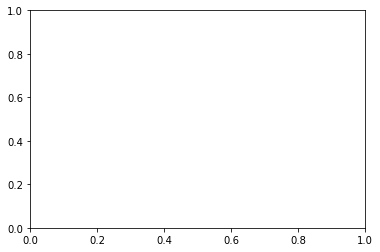

In [339]:
# compute correlation
all_rels = {}
for sid in range(100):
    go = False
    tree = dataset[sid]
    input_ids = tree.ndata['x'] # word id of the node
    labels = tree.ndata['y'] #  label of the node
    mask = tree.ndata['mask'] # 1 if the node is a leaf, otherwise 0
    # adj= tree.adj()

    lsent = [ words[idw] for idw in input_ids[mask == 1]]
    sentence = make_text_string(lsent)

    label = labels[0] 

    target = torch.tensor([-1,1])

    explainer = HOExplainer(model)
    explainer.setup_sample(sentence,target)
    
    if len(explainer.words) -2 == len(lsent) and len(lsent) < 15: 
        print('nb_tokens:', len(explainer.words), 'nb_words:', len(lsent))
        print(sentence)
        go = True
#     if go: 
        rels = explainer.explain()
        all_rels[sid] = rels
        go = False




or 0.699


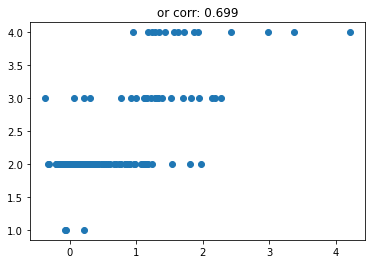

subset 0.506


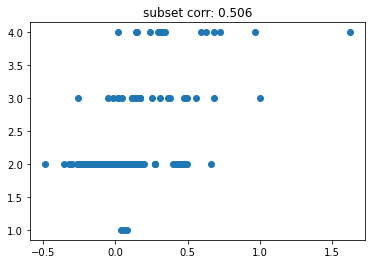

1od 0.695


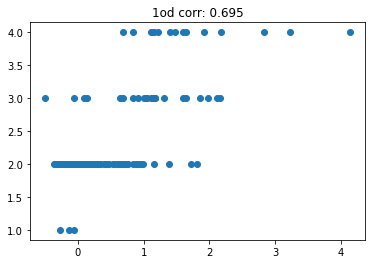

In [356]:
for mode in ['or', 'subset', '1od']:
    node_heat_gt = []
    node_rels = []
    for sid, rels in all_rels.items():
        tree = tree = dataset[sid]
        labels = tree.ndata['y']
        node_heat_gt += [float(label) for label in labels]
        node_rels += comp_tree_node_rels(rels, tree, mode)

    plt.scatter(node_rels, node_heat_gt)
    corr = round(np.corrcoef(node_rels, y=node_heat_gt)[0,1], 3)
    print(mode, corr)
    plt.title(mode + f' corr: {corr}')
    plt.show()

In [24]:
from xai_utils import create_text_heat_map
print("------------------")
print("Effect of feature 'bleak':")
R = np.zeros(len(words))
R_6 = symb_xai(rels, (6,), mode='and')
R[6] = R_6
print('rel', R_6)
display(HTML(create_text_heat_map(words, R.squeeze())))

print("------------------")
print("Effect of feature 'desperate':")
R = np.zeros(len(words))
R_8 = symb_xai(rels, (8,), mode='and')
R[8] = R_8
print('rel', R_8)
display(HTML(create_text_heat_map(words, R.squeeze())))

print("------------------")
print("Joint effect of features 'bleak' and 'desperate':")
R = np.zeros(len(words))
R_68 = symb_xai(rels, (6, 8), mode='and')
R[6] = R_68
R[8] = R_68
print('rel', R_68)
display(HTML(create_text_heat_map(words, R.squeeze())))
print("------------------")

print("------------------")
print("Joint effect of features 'bleak', 'and', and 'desperate':")
R = np.zeros(len(words))
R_678 = symb_xai(rels, (6, 7, 8), mode='and')
R[6] = R_678
R[7] = R_678
R[8] = R_678
print('rel', R_678)
display(HTML(create_text_heat_map(words, R.squeeze())))
print("------------------")

------------------
Effect of feature 'bleak':
rel 0.1797429032326363


------------------
Effect of feature 'desperate':
rel 0.2802975700337811


------------------
Joint effect of features 'bleak' and 'desperate':
rel 0.02442454126503435


------------------
------------------
Joint effect of features 'bleak', 'and', and 'desperate':
rel 0.000545854516531108


------------------
